# Bootstrapping for each replicate

## Data analysis: Linear model fit and volume corrected moments

In [1]:
using Random, Plots, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures

In [2]:
df = DataFrame(CSV.File("FISH_toShare_NoTSlabel_celldata_long_220620_simple_woMad3Outlier_withColDescription.csv"));

In [3]:
names(df);

In [4]:
df = df[:,[:sampleID,:gene,:NucleiCount,:Compartment,:CountMethod,:RNAperCell,:Cell_Length_um]];

In [5]:
# filter only for mad1WTGFP and NucleiCount = 1
dfa = subset(df, :gene => g -> g.=="mad1WTymEGFP", :NucleiCount => n -> n.==1)
# make cyto and nuc table separately.
dfcyto = subset(dfa, :Compartment=>c->c.=="Cytoplasm")
dfnuc = subset(dfa, :Compartment=>c->c.=="Nucleus")
# separate the 4 different samples
dfsN = [];dfsC = [];
samples = unique(dfa[!,:sampleID])
# add each to the vectors
for i in 1:4
    samp = samples[1]
    dftempN = subset(dfnuc, :sampleID=>S->S.==samples[i])
    dftempC = subset(dfcyto, :sampleID=>S->S.==samples[i])
    push!(dfsN,dftempN)
    push!(dfsC,dftempC)
end

In [6]:
dfsC;

If the moments I find differ from this then I know there's an issue! Let's collect the columns corresponding to the nuclear and cytoplasmic volumes and **counts** respectively.

In [7]:
names(dfsC[1])

7-element Vector{String}:
 "sampleID"
 "gene"
 "NucleiCount"
 "Compartment"
 "CountMethod"
 "RNAperCell"
 "Cell_Length_um"

In [8]:
n_vols = [dfsN[i][!,:Cell_Length_um] for i in 1:4]
c_vols = [dfsC[i][!,:Cell_Length_um] for i in 1:4]
n_ints = [dfsN[i][!,:RNAperCell] for i in 1:4]
c_ints = [dfsC[i][!,:RNAperCell] for i in 1:4];

In [32]:
Ns = [length(c_ints[i]) for i in 1:4]

4-element Vector{Int64}:
 1161
 1581
 1977
 1746

For the linear model fits we use the Julia package GLM. This is a very convenient and fast way to construct linear models.

In [10]:
using GLM

Perform the linear model fits. Note in the below that our fitting parameters are stored in `npar` and `cpar` in the order `[intercept, gradient]`.

In [11]:
nlms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsN[i]) for i in 1:4]
npars = [coef(nlms[i]) for i in 1:4]
cs = hcat(npars...)[1,:]; ds = hcat(npars...)[2,:]
clms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsC[i]) for i in 1:4]
cpars = [coef(clms[i]) for i in 1:4]
as = hcat(cpars...)[1,:]; bs = hcat(cpars...)[2,:]

4-element Vector{Float64}:
 0.6037905581610079
 0.46608863627967206
 0.4796026025612281
 0.37971856092997336

A quick look at the linear model fit itself will tell us some properties of the fit.

In [12]:
clms[1]

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

RNAperCell ~ 1 + Cell_Length_um

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)     -3.16679    0.240588   -13.16    <1e-36  -3.63882   -2.69475
Cell_Length_um   0.603791   0.0228683   26.40    <1e-99   0.558923   0.648658
─────────────────────────────────────────────────────────────────────────────

Now, to construct the volume corrected moments we first need to know the mean values for the volumes and intensities. Collect these from the data.

In [13]:
n_vol_avgs = [mean(n_vols[i]) for i in 1:4]
c_vol_avgs = [mean(c_vols[i]) for i in 1:4]
n_avgs = [mean(n_ints[i]) for i in 1:4]
c_avgs = [mean(c_ints[i]) for i in 1:4]

4-element Vector{Float64}:
 3.094988234996555
 2.6687301433055026
 2.9580443633353566
 2.610546234022337

Note that even the means of the cytoplasmic can vary quite significantly between the replicates. As can the observed mean cell volumes in each experiment.

We know theoretically that to first order volume corrections to the means are nil. Let's just clarify this.

In [14]:
ds

4-element Vector{Float64}:
 0.024634400218522125
 0.05869752331164149
 0.04127424654051097
 0.01671396006187003

In [15]:
vc_mean_ns = [cs[i] + n_vol_avgs[i]*ds[i] for i in 1:4]
vc_mean_cs = [as[i] + c_vol_avgs[i]*bs[i] for i in 1:4]
# vc_mean_cs = a + c_vol_avg*b

4-element Vector{Float64}:
 3.094988234996555
 2.668730143305501
 2.958044363335355
 2.610546234022334

In [16]:
μ20s = [moment(n_ints[i], 2, n_avgs[i]) for i in 1:4];
μ02s = [moment(c_ints[i], 2, c_avgs[i]) for i in 1:4];
μ20Ωs = [moment(n_vols[i], 2, n_vol_avgs[i]) for i in 1:4];
μ02Ωs = [moment(c_vols[i], 2, c_vol_avgs[i]) for i in 1:4];

In [17]:
μ20s_i = [μ20s[i] - ds[i]^2 * μ20Ωs[i] for i in 1:4]
μ02s_i = [μ02s[i] - bs[i]^2 * μ02Ωs[i] for i in 1:4];

Clearly the volume corrected means are simply the means if one averaged over the data. Can now store the values for the VC FF's along with the mean cyto #.

In [18]:
nuc_FFs = μ20s_i./vc_mean_ns

4-element Vector{Float64}:
 0.9558150606258131
 0.9926999917678184
 0.9744213797386199
 0.997142602245176

In [19]:
cyto_FFs = μ02s_i./vc_mean_cs

4-element Vector{Float64}:
 0.6129543833434689
 0.7557568194063666
 0.6613100531460392
 0.5879024967862935

In [20]:
cyto_means = vc_mean_cs

4-element Vector{Float64}:
 3.094988234996555
 2.668730143305501
 2.958044363335355
 2.610546234022334

# Now for the bootstraps

In [21]:
sample([1,2,3],1)

1-element Vector{Int64}:
 3

In [22]:
test = [1,2,4]

3-element Vector{Int64}:
 1
 2
 4

In [23]:
test[[1,3]]

2-element Vector{Int64}:
 1
 4

In [24]:
nlms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsN[i]) for i in 1:4]
npars = [coef(nlms[i]) for i in 1:4]
cs = hcat(npars...)[1,:]; ds = hcat(npars...)[2,:]
clms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsC[i]) for i in 1:4]
cpars = [coef(clms[i]) for i in 1:4]
as = hcat(cpars...)[1,:]; bs = hcat(cpars...)[2,:]

4-element Vector{Float64}:
 0.6037905581610079
 0.46608863627967206
 0.4796026025612281
 0.37971856092997336

In [25]:
function bootstrap_samps(n_pop,c_pop,v_pop,N)
    if length(n_pop)!=length(c_pop)
        return error("args must be the same length")
    end
    # make an array of all the indices
    all_inds = collect(1:1:length(n_pop))
    samps = [sort(sample(all_inds,N)) for i in 1:5000]
    n_samps = [n_pop[samps[i]] for i in 1:5000]
    c_samps = [c_pop[samps[i]] for i in 1:5000]
    v_samps = [v_pop[samps[i]] for i in 1:5000]
    meanCs = zeros(5000); ffNs = zeros(5000); ffCs = zeros(5000);
    # for each bootstrapped sample we now need the vol corr moments.
    for j in 1:5000
        ns = n_samps[j]; cs = c_samps[j]; vs = v_samps[j];
        dftemp = DataFrame(vol=vs,n=ns,c=cs);
        nlm = lm(@formula(n ~ vol), dftemp);
        npars = coef(nlm); c = npars[1]; d = npars[2];
        clm = lm(@formula(c ~ vol), dftemp);
        cpars = coef(clm); a = cpars[1]; b = cpars[2];
        navg = mean(ns); cavg = mean(cs); vavg = mean(vs);
        μ20 = moment(ns, 2, navg);
        μ02 = moment(cs, 2, cavg);
        μ2Ω = moment(vs, 2, vavg);
        μ20_i = μ20 - d^2 * μ2Ω;
        μ02_i = μ02 - b^2 * μ2Ω;
        meanCs[j] = cavg; ffNs[j] = μ20_i/navg; ffCs[j] = μ02_i/cavg;
    end
    return meanCs, ffNs, ffCs
end
ti = 3
test = bootstrap_samps(n_ints[3],c_ints[3],n_vols[3],Ns[3])

([2.9745887980510877, 2.984431363901872, 2.888064062489125, 2.9260402231446645, 2.9951410746757716, 3.02082730578604, 2.9864822079291855, 2.953047938226606, 2.902172644996965, 2.957106755398078  …  3.018251696054122, 2.9687033480091047, 2.9836170399109765, 2.974730394433485, 2.9079929328973195, 2.886607414041477, 2.912417373208902, 2.9024643065457765, 2.9313579371279714, 2.9058491947991905], [0.8932110691673079, 0.9862105882714282, 0.9922532016904746, 1.0130060188037089, 1.026486209872651, 1.0262297285011484, 0.9576510466962921, 0.9870059373656768, 0.9634811513575993, 0.9846824570804463  …  0.9093213158560675, 0.9416915907009894, 0.9514818363787845, 0.955087072351182, 0.9889519771047394, 0.9563125984649726, 0.9634741105299447, 0.9782829130369042, 0.9875338245040018, 0.9156765138464096], [0.616872248140305, 0.6896571708698329, 0.6979730404336275, 0.6711041377118443, 0.6523483889907429, 0.6177152078637216, 0.620740931166628, 0.6534749448812519, 0.6875832584460211, 0.6524681661382491  …  

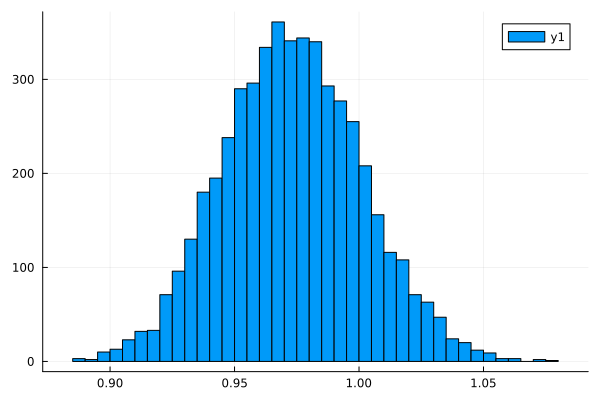

In [26]:
histogram(test[2])

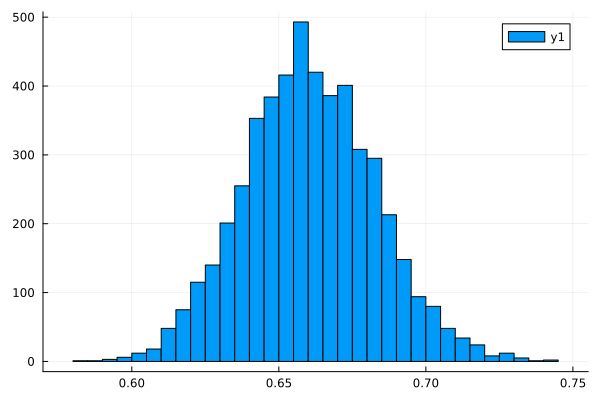

In [27]:
histogram(test[3])

## Can now see the bootstrapped stds for everything

In [35]:
bs1samp = bootstrap_samps(n_ints[1],c_ints[1],n_vols[1],Ns[1])
c1var = var(bs1samp[1]); ffn1var = var(bs1samp[2]); ffc1var = var(bs1samp[3]);
[c1var,ffn1var,ffc1var].^1/2

3-element Vector{Float64}:
 0.0012944543324093665
 0.0008691122893669178
 0.00035717750319579696

In [36]:
bs2samp = bootstrap_samps(n_ints[2],c_ints[2],n_vols[2],Ns[2])
c2var = var(bs2samp[1]); ffn2var = var(bs2samp[2]); ffc2var = var(bs2samp[3]);
[c2var,ffn2var,ffc2var].^1/2

3-element Vector{Float64}:
 0.0008812115899727333
 0.0005759451133844373
 0.0005468310855073908

In [37]:
bs3samp = bootstrap_samps(n_ints[3],c_ints[3],n_vols[3],Ns[3])
c3var = var(bs3samp[1]); ffn3var = var(bs3samp[2]); ffc3var = var(bs3samp[3]);
[c3var,ffn3var,ffc3var].^1/2

3-element Vector{Float64}:
 0.0006792175099262512
 0.00038133491212896805
 0.00023854006755847325

In [38]:
bs4samp = bootstrap_samps(n_ints[4],c_ints[4],n_vols[4],Ns[4])
c4var = var(bs4samp[1]); ffn4var = var(bs4samp[2]); ffc4var = var(bs4samp[3]);
[c4var,ffn4var,ffc4var].^1/2

3-element Vector{Float64}:
 0.0005545604525713435
 0.0005586469600258649
 0.000180552223878075